#### In this assignment, you will learn one approach to detect potential bias, by analyzing correlations in feature classifications on the generated images.



#### Packages and Visualization

In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generator and Noise

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Classifier

In [4]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing classes.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

#### Loading the pre-trained models

In [6]:
z_dim = 64
batch_size = 128
device = 'cuda'

In [7]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


#### Feature Correlation

In [14]:
# First we generate a bunch of fake images using the generator
n_images = 256
fake_image_history = []
classification_history = []
# How many gradient steps to take
grad_steps = 30
# How many gradient steps to skip in the visualization
skip = 2

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

# Additive Direction (more of a feature)
for i in range(grad_steps):
    
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data += new_noise.grad / grad_steps
    
# Subtractive direction (less of a feature)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps
    
classification_history = torch.stack(classification_history)

In [17]:
classification_history.shape

torch.Size([60, 256, 40])

In [19]:
starting_classifications[None, :, :].shape

torch.Size([1, 256, 40])

You've now generated image samples, which have increasing or decreasing amounts of the target feature. You can visualize the way in which that affects other classified features. The x-axis will show you the amount of change in your target feature and the y-axis shows how much the other features change, as detected in those images by the classifier. Together, you will be able to see the covariance of "male-ness" and other features

C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

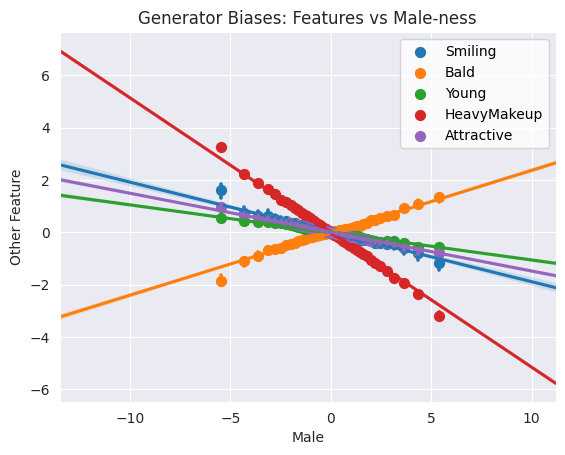

In [21]:
import seaborn as sns

other_features = ['Smiling', 'Bald', 'Young', 'HeavyMakeup', 'Attractive']
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()

for other_feature in other_features:
    
    other_indices = feature_names.index(other_feature)
    
    with sns.axes_style('darkgrid'):
        
        sns.regplot(
            classification_changes[:, :, target_indices].reshape(-1),
            classification_changes[:, :, other_indices].reshape(-1),
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

#### Quantification

Finally, you can also quantitatively evaluate the degree to which these factors covary.



In [ ]:
def get_top_covariances(classification_changes, target_index, top_n=10):
    
    